<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analysis-Packages" data-toc-modified-id="Analysis-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analysis Packages</a></span></li><li><span><a href="#Cell-Metadata" data-toc-modified-id="Cell-Metadata-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cell Metadata</a></span></li><li><span><a href="#Metadata-on-plate-view" data-toc-modified-id="Metadata-on-plate-view-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metadata on plate view</a></span><ul class="toc-item"><li><span><a href="#CH_RateAdj" data-toc-modified-id="CH_RateAdj-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CH_RateAdj</a></span></li><li><span><a href="#FinalReads" data-toc-modified-id="FinalReads-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>FinalReads</a></span></li></ul></li><li><span><a href="#Cell-QC-metric" data-toc-modified-id="Cell-QC-metric-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cell QC metric</a></span></li></ul></div>

# Data Walkthrough

## Analysis Packages
- [cemba_data](https://github.com/lhqing/cemba_data): our inhouse analysis package used for daily analysis. This package is not intend to broadly share because its actively changing.
- [ALLCools](https://github.com/lhqing/ALLCools): our formal methylation data preprocess/analysis package. Most cemba_data will be moved to this package once its mature enough.


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scanpy.api as sc
import anndata

import matplotlib.pyplot as plt
import seaborn as sns
from cemba_data.tools.hdf5.netndf import MCDS
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate
from cemba_data.local.mc.prepare_study import prepare_study

## Cell Metadata

In [2]:
cell_meta = pd.read_csv(
    '../dataset/mC/MOp_Metadata.tsv.gz', sep='\t', index_col=0)

- CG_RateAdj: (mCG% - mCCC%) / (1 - mCCC%)
- CH_RateAdj: (mCH% - mCCC%) / (1 - mCCC%)
- InputReads: Total number of reads after barcode trimming and reads base quality trimming and filtering.
- MappedReads: Total number of reads after mapping
- FinalReads: Total number of reads after filtering by mapping quality, PCR duplicates.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


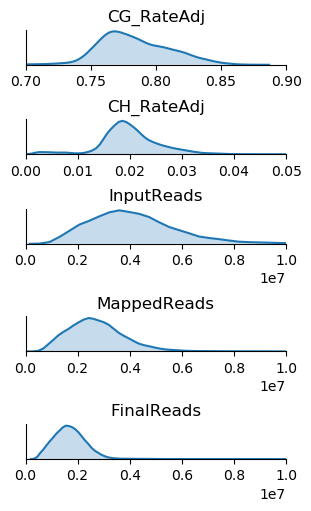

In [3]:
fig, axes = plt.subplots(
    nrows=5, constrained_layout=True, figsize=(3, 5), dpi=100)
xlims = [(0.7, 0.9), (0, 0.05), (0, 1e7), (0, 1e7), (0, 1e7)]
for col, xlim, ax in zip(
    ['CG_RateAdj', 'CH_RateAdj', 'InputReads', 'MappedReads', 'FinalReads'], xlims,
        axes.flat):
    sns.kdeplot(cell_meta[col], ax=ax, shade=True, legend=False)
    ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
sns.despine(fig=fig, trim=True)

## Metadata on plate view
- We use NeuN antibody to sort single nucleus into each well of 384 plate
- Col 1-22 are NeuN+ cells, Col 23-24 are NeuN- cells, they have very different overall mCH level.
- CEMBA171212_4B_1 was in low quality. But usually the mechanical issue only impact the number of cells we got, but do not intriduce large molecular profile change.
- Our recent library on other regions is more uniform and well controled.
- We usually plot all metadata onto original plate to get a better idea about how different library prep batchs looks like and which one may have some issue.

### CH_RateAdj

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


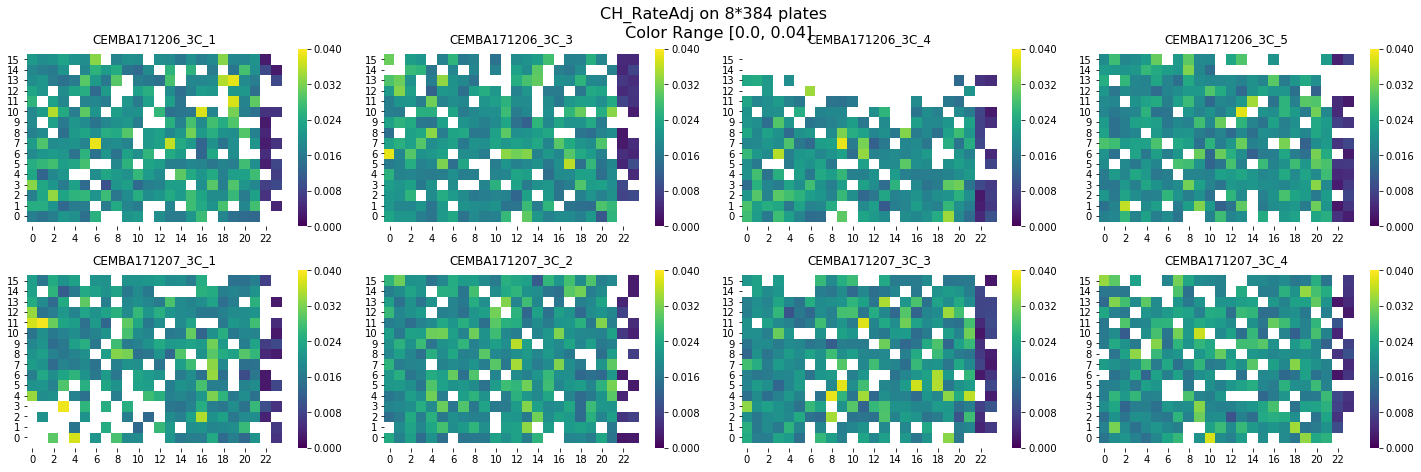

In [5]:
fig, axes = plot_on_plate(cell_meta[cell_meta['Region'] == '3C'], 'CH_RateAdj', 'Plate', vmin=0., vmax=0.04, 
                          heatmap_kws={'linewidth': 0, 'linecolor': '#EEEEEE'}, 
                          aggregation_func=lambda i: i.mean())

### FinalReads

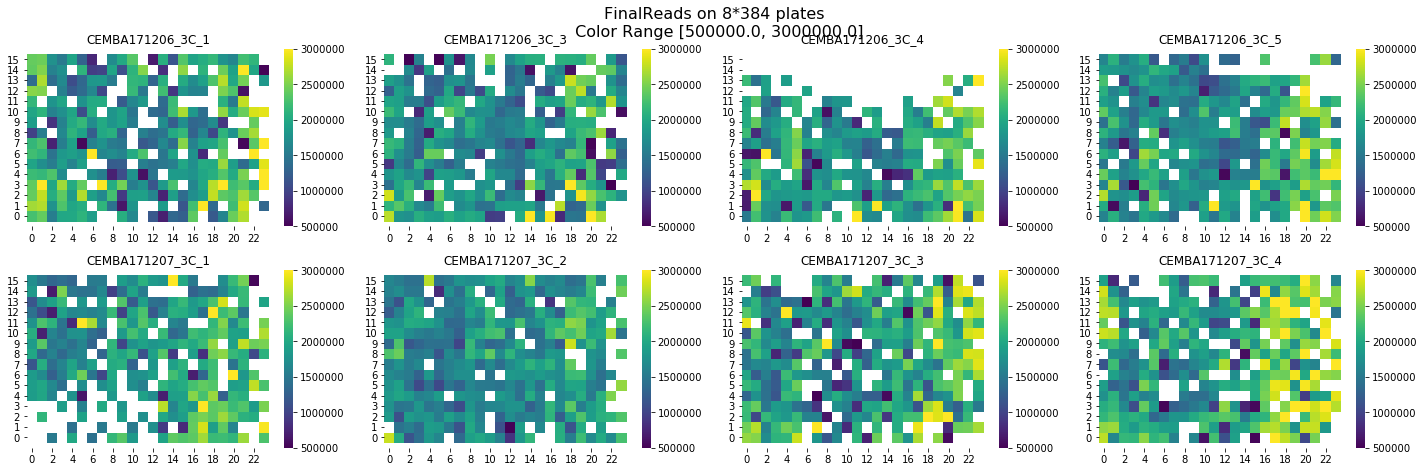

In [7]:
fig, axes = plot_on_plate(cell_meta[cell_meta['Region'] == '3C'], 'FinalReads', 'Plate', vmin=5e5, vmax=3e6, 
                          heatmap_kws={'linewidth': 0, 'linecolor': '#EEEEEE'}, 
                          aggregation_func=lambda i: i.mean())

## Cell QC metric

In [8]:
qc_metric = {
    'CCC_Rate': (0, 0.02),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

In [9]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

In [10]:
cell_meta.to_csv('Metadata.after_QC.msg', sep='\t')
cell_meta.to_msgpack('Metadata.after_QC.msg')